In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.metrics import mean_squared_error
import seaborn as sns

# Define the mlfow experiment after running mlflow with the sqlite backend
import mlflow
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('nyc-taxi-1')

2023/04/09 07:24:11 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2023/04/09 07:24:11 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


<Experiment: artifact_location='/home/ubuntu/mlops_joses/notebooks/mlruns/1', creation_time=1681015702924, experiment_id='1', last_update_time=1681015702924, lifecycle_stage='active', name='nyc-taxi-1', tags={}>

In [3]:
df = pd.read_parquet('data/green_tripdata_2021-01.parquet')

# Create a duration column to calculate the lenght of each trip in minutes
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda x: x.total_seconds()/60)

# Select only rows where the duration is between 1-60 minuts
df = df[(df.duration>=1) & (df.duration<=60)].reset_index(drop=True)

# Select only rows where the taxis were dispatched
# df = df[df.trip_type == 2].reset_index(drop=True)
display(df.head())

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
4,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667


### Print the preliminary stats and plot the distribution of the target variable

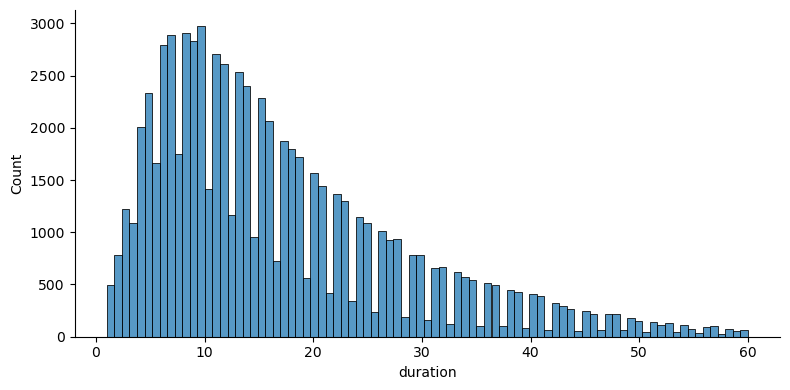

In [8]:
# df.dtypes
# display(df.duration.describe(percentiles=[0.95,0.98,0.99]))
sns.displot(df.duration, height=4,aspect=2).fig.set_dpi(100)
plt.show()

### Select the columns to train the model and perform one-hot encoding (OHE) on catergorical columns

In [9]:
categorical = ['PULocationID','DOLocationID']
numerical = ['trip_distance']

# Convert the categorical columns to string so the OHE will work
df[categorical] = df[categorical].astype(str)

# Call the dictionary vectorizer from sklearn
dv = DictVectorizer()

# Convert the columns of interest to a dictionary
train_dicts = df[categorical + numerical].to_dict(orient='records')

### Create the training data

In [10]:
X_train = dv.fit_transform(train_dicts)
# To view all the categorical locations
# print(dv.feature_names_)

### Create the target dataset

In [11]:
target = 'duration'
y_train = df[target].to_numpy()

### Create the model

In [12]:
lr  = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

### Plot the difference between the trained and predicted data

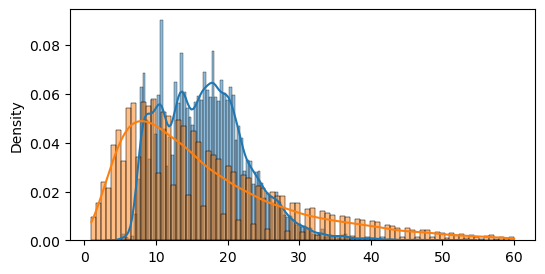

In [13]:
fig,ax = plt.subplots(1,1,figsize=(6,3))
sns.histplot(y_pred, label='prediction', ax=ax, kde=True, stat="density")
sns.histplot(y_train, label='actual', ax=ax, kde=True, stat="density")
plt.show()

In [14]:
# Setting squared to False is like rms
mse = mean_squared_error(y_train, y_pred, squared=False)
print(f'The baseline model is wrong by {mse:.2f} minutes')

The baseline model is wrong by 9.84 minutes


### Create a function to load and preprocess datasets by file paths

In [2]:
def load_data(path):
    df = pd.read_parquet(path)

    # Create a duration column to calculate the lenght of each trip in minutes
    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda x: x.total_seconds()/60)

    # Select only rows where the duration is between 1-60 minuts
    df = df[(df.duration>=1) & (df.duration<=60)].reset_index(drop=True)
    
    categorical = ['PULocationID','DOLocationID']
    # Convert the categorical columns to string so the OHE will work
    df[categorical] = df[categorical].astype(str)
    
    # Merge the pickup and drop off locations
    df['PU_DO'] = df['PULocationID'] + '_' + df['DOLocationID']
    
    return df


### Load the training dataframes

In [3]:
df_train = load_data('data/green_tripdata_2021-01.parquet') # January
df_val = load_data('data/green_tripdata_2021-02.parquet') # February

### Prepare the training dataset

In [4]:
categorical = ['PU_DO']
numerical = ['trip_distance']

# Call the dictionary vectorizer from sklearn
dv = DictVectorizer()

# Convert the columns of interest to a dictionary
train_dict = df_train[categorical + numerical].to_dict(orient='records')
val_dict = df_val[categorical + numerical].to_dict(orient='records')

# Create the training and test data
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Create the target variables
y_train = df_train['duration'].to_numpy()
y_val = df_val['duration'].to_numpy()

### Train the model and predict on the validation dataset

In [5]:
lr  = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

### Plot the difference between the training and predicition

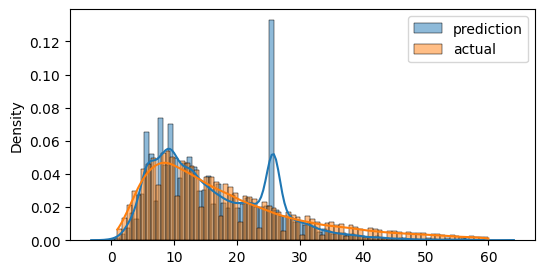

In [6]:
fig,ax = plt.subplots(1,1,figsize=(6,3))
sns.histplot(y_pred, label='prediction', ax=ax, kde=True, stat="density")
sns.histplot(y_val, label='actual', ax=ax, kde=True, stat="density")
plt.legend()
plt.show()

### Print the model errors

In [7]:
# Setting squared to False is like rms
mse = mean_squared_error(y_val, y_pred, squared=False)
print(f'The baseline model is wrong by {mse:.2f} minutes')

The baseline model is wrong by 7.76 minutes


### Save the trained model

In [8]:
# Save the model
with open('models/lin_reg.bin','wb') as f_out:
    pickle.dump((dv, lr), f_out)

### Train a Lasso Model
To log the different runs with MLFlow

In [15]:
with mlflow.start_run():
    
    # Set the name of the developer running the code
    mlflow.set_tag('developer','Joses') 
    
    # Set the name of the parameters used for a run
    mlflow.log_param('train-data-path','data/green_tripdata_2021-01.parquet')
    mlflow.log_param('val-data-path','data/green_tripdata_2021-02.parquet')
    
    
    alpha = 0.01 # This can be the learning rate or loss in a tf model
    mlflow.log_param('alpha',alpha)
    
    
    lasr = Lasso(alpha)
    lasr.fit(X_train, y_train)

    y_pred = lasr.predict(X_val)

    # Setting squared to False is like rms
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    # Also log the rmse to know how well the model performed
    mlflow.log_metric('rmse', rmse)
    
    # Save the model to the local disk
    with open('models/lasso_reg.bin','wb') as f_out:
        pickle.dump((dv, lasr), f_out)
    
    # Loop the saved model into an mlflow run
    mlflow.log_artifact(local_path='models/lasso_reg.bin', artifact_path='model')
    
    
    print(f'The Lasso model is wrong by {rmse:.2f} minutes')

The Lasso model is wrong by 11.17 minutes


### To better demonstrate how mlflow works, we'll track things with XgBoost

In [6]:
import xgboost as xgb

# Does Bayesian opt to reduce loss
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

### Define the xgboost objective function which saves every model run

In [7]:
# --- Convert the training and validation data to xgboost compatible matrix ----
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)


def objective(params):
    '''Objective function for xgboost'''
    with mlflow.start_run():
        mlflow.set_tag('model','xgboost')
        mlflow.log_params(params)
        
        booster = xgb.train(params=params, dtrain=train,num_boost_round=1000,
                            evals=[(valid,'validation')], early_stopping_rounds=50)
        
        y_pred = booster.predict(valid)
        
        # Setting squared to False is like rms
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        # Also log the rmse to know how well the model performed
        mlflow.log_metric('rmse', rmse)

#         print(f'The XgBoost model is wrong by {mse:.2f} minutes')
        
    return {'loss': rmse, 'status': STATUS_OK}

### Implement a hyperparameter grid search to the best model 

In [19]:
# --- Define the search space for xgboost ---
search_space = {'max_depth': scope.int(hp.quniform('max_depth', 4,100,1)),
                # --- Loguiform does exponent of low and high values as ranges --- 
                'learning_rate': hp.loguniform('learning_rate', -3, 0), 
                'reg_alpha': hp.loguniform('reg_alpha',-5,-1),
                'reg_lambda': hp.loguniform('reg_lambda',-6,-1),
                'min_child_weight': hp.loguniform('min_child_weight',-1,3),
                'objective': 'reg:linear',
                'seed': 42}

# Execute the model with the objective function and bayesian hyperparameter tuning
best_result = fmin(fn=objective, 
                   space=search_space,
                   algo=tpe.suggest,
                   max_evals=50,
                   trials=Trials())

[06:07:05] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:13.21203                                                    
[1]	validation-rmse:9.40857                                                     
[2]	validation-rmse:7.74598                                                     
[3]	validation-rmse:7.05861                                                     
[4]	validation-rmse:6.76289                                                     
[5]	validation-rmse:6.62814                                                     
[6]	validation-rmse:6.55887                                                     
[7]	validation-rmse:6.52382                                                     
[8]	validation-rmse:6.50750                                                     
[9]	validation-rmse:6.49492                                                     
[10]	validation-rmse:6.48675                                           

[0]	validation-rmse:18.76320                                                    
[1]	validation-rmse:16.69756                                                    
[2]	validation-rmse:14.94903                                                    
[3]	validation-rmse:13.47645                                                    
[4]	validation-rmse:12.24205                                                    
[5]	validation-rmse:11.21172                                                    
[6]	validation-rmse:10.35883                                                    
[7]	validation-rmse:9.65457                                                     
[8]	validation-rmse:9.07573                                                     
[9]	validation-rmse:8.60910                                                     
[10]	validation-rmse:8.22685                                                    
[11]	validation-rmse:7.91815                                                    
[12]	validation-rmse:7.66795

[202]	validation-rmse:6.46938                                                   
[203]	validation-rmse:6.46916                                                   
[204]	validation-rmse:6.46909                                                   
[205]	validation-rmse:6.46901                                                   
[206]	validation-rmse:6.46901                                                   
[207]	validation-rmse:6.46887                                                   
[208]	validation-rmse:6.46867                                                   
[209]	validation-rmse:6.46868                                                   
[210]	validation-rmse:6.46858                                                   
[211]	validation-rmse:6.46858                                                   
[212]	validation-rmse:6.46866                                                   
[213]	validation-rmse:6.46856                                                   
[214]	validation-rmse:6.4686

[131]	validation-rmse:6.53086                                                   
[132]	validation-rmse:6.53075                                                   
[133]	validation-rmse:6.53058                                                   
[134]	validation-rmse:6.53044                                                   
[135]	validation-rmse:6.52964                                                   
[136]	validation-rmse:6.52921                                                   
[137]	validation-rmse:6.52800                                                   
[138]	validation-rmse:6.52765                                                   
[139]	validation-rmse:6.52768                                                   
[140]	validation-rmse:6.52750                                                   
[141]	validation-rmse:6.52669                                                   
[142]	validation-rmse:6.52640                                                   
[143]	validation-rmse:6.5258

[333]	validation-rmse:6.50524                                                   
[334]	validation-rmse:6.50521                                                   
[335]	validation-rmse:6.50513                                                   
[336]	validation-rmse:6.50501                                                   
[337]	validation-rmse:6.50495                                                   
[338]	validation-rmse:6.50488                                                   
[339]	validation-rmse:6.50482                                                   
[340]	validation-rmse:6.50476                                                   
[341]	validation-rmse:6.50486                                                   
[342]	validation-rmse:6.50494                                                   
[343]	validation-rmse:6.50523                                                   
[344]	validation-rmse:6.50518                                                   
[345]	validation-rmse:6.5051

[535]	validation-rmse:6.50136                                                   
[536]	validation-rmse:6.50151                                                   
[537]	validation-rmse:6.50153                                                   
[538]	validation-rmse:6.50151                                                   
[539]	validation-rmse:6.50148                                                   
[540]	validation-rmse:6.50145                                                   
[541]	validation-rmse:6.50141                                                   
[542]	validation-rmse:6.50156                                                   
[543]	validation-rmse:6.50164                                                   
[544]	validation-rmse:6.50173                                                   
[545]	validation-rmse:6.50170                                                   
[546]	validation-rmse:6.50172                                                   
[547]	validation-rmse:6.5017

[175]	validation-rmse:6.61852                                                   
[176]	validation-rmse:6.61839                                                   
[177]	validation-rmse:6.61814                                                   
[178]	validation-rmse:6.61782                                                   
[179]	validation-rmse:6.61760                                                   
[180]	validation-rmse:6.61739                                                   
[181]	validation-rmse:6.61735                                                   
[182]	validation-rmse:6.61717                                                   
[183]	validation-rmse:6.61706                                                   
[184]	validation-rmse:6.61668                                                   
[185]	validation-rmse:6.61667                                                   
[186]	validation-rmse:6.61661                                                   
[187]	validation-rmse:6.6163

[377]	validation-rmse:6.60370                                                   
[378]	validation-rmse:6.60353                                                   
[379]	validation-rmse:6.60364                                                   
[380]	validation-rmse:6.60352                                                   
[381]	validation-rmse:6.60350                                                   
[382]	validation-rmse:6.60333                                                   
[383]	validation-rmse:6.60335                                                   
[384]	validation-rmse:6.60332                                                   
[385]	validation-rmse:6.60304                                                   
[386]	validation-rmse:6.60319                                                   
[387]	validation-rmse:6.60313                                                   
[388]	validation-rmse:6.60307                                                   
[389]	validation-rmse:6.6030

[55]	validation-rmse:6.60837                                                    
[56]	validation-rmse:6.60778                                                    
[57]	validation-rmse:6.60703                                                    
[58]	validation-rmse:6.60606                                                    
[59]	validation-rmse:6.60495                                                    
[60]	validation-rmse:6.60468                                                    
[61]	validation-rmse:6.60389                                                    
[62]	validation-rmse:6.60268                                                    
[63]	validation-rmse:6.60173                                                    
[64]	validation-rmse:6.60116                                                    
[65]	validation-rmse:6.60055                                                    
[66]	validation-rmse:6.59949                                                    
[67]	validation-rmse:6.59866

[257]	validation-rmse:6.48697                                                   
[258]	validation-rmse:6.48685                                                   
[259]	validation-rmse:6.48653                                                   
[260]	validation-rmse:6.48551                                                   
[261]	validation-rmse:6.48520                                                   
[262]	validation-rmse:6.48493                                                   
[263]	validation-rmse:6.48465                                                   
[264]	validation-rmse:6.48472                                                   
[265]	validation-rmse:6.48459                                                   
[266]	validation-rmse:6.48411                                                   
[267]	validation-rmse:6.48368                                                   
[268]	validation-rmse:6.48335                                                   
[269]	validation-rmse:6.4832

[459]	validation-rmse:6.44330                                                   
[460]	validation-rmse:6.44317                                                   
[461]	validation-rmse:6.44321                                                   
[462]	validation-rmse:6.44290                                                   
[463]	validation-rmse:6.44254                                                   
[464]	validation-rmse:6.44228                                                   
[465]	validation-rmse:6.44216                                                   
[466]	validation-rmse:6.44198                                                   
[467]	validation-rmse:6.44178                                                   
[468]	validation-rmse:6.44153                                                   
[469]	validation-rmse:6.44153                                                   
[470]	validation-rmse:6.44139                                                   
[471]	validation-rmse:6.4411

[661]	validation-rmse:6.42091                                                   
[662]	validation-rmse:6.42086                                                   
[663]	validation-rmse:6.42089                                                   
[664]	validation-rmse:6.42110                                                   
[665]	validation-rmse:6.42105                                                   
[666]	validation-rmse:6.42099                                                   
[667]	validation-rmse:6.42105                                                   
[668]	validation-rmse:6.42099                                                   
[669]	validation-rmse:6.42084                                                   
[670]	validation-rmse:6.42088                                                   
[671]	validation-rmse:6.42084                                                   
[672]	validation-rmse:6.42083                                                   
[673]	validation-rmse:6.4205

[863]	validation-rmse:6.41060                                                   
[864]	validation-rmse:6.41055                                                   
[865]	validation-rmse:6.41053                                                   
[866]	validation-rmse:6.41051                                                   
[867]	validation-rmse:6.41049                                                   
[868]	validation-rmse:6.41041                                                   
[869]	validation-rmse:6.41037                                                   
[870]	validation-rmse:6.41028                                                   
[871]	validation-rmse:6.41021                                                   
[872]	validation-rmse:6.41008                                                   
[873]	validation-rmse:6.40990                                                   
[874]	validation-rmse:6.40990                                                   
[875]	validation-rmse:6.4101

[63]	validation-rmse:6.50960                                                    
[64]	validation-rmse:6.50941                                                    
[65]	validation-rmse:6.50749                                                    
[66]	validation-rmse:6.50875                                                    
[67]	validation-rmse:6.50732                                                    
[68]	validation-rmse:6.50719                                                    
[69]	validation-rmse:6.50583                                                    
[70]	validation-rmse:6.50522                                                    
[71]	validation-rmse:6.50402                                                    
[72]	validation-rmse:6.50098                                                    
[73]	validation-rmse:6.49909                                                    
[74]	validation-rmse:6.49746                                                    
[75]	validation-rmse:6.49761

[6]	validation-rmse:6.61224                                                     
[7]	validation-rmse:6.55651                                                     
[8]	validation-rmse:6.52575                                                     
[9]	validation-rmse:6.50705                                                     
[10]	validation-rmse:6.49738                                                    
[11]	validation-rmse:6.48866                                                    
[12]	validation-rmse:6.48221                                                    
[13]	validation-rmse:6.47756                                                    
[14]	validation-rmse:6.47269                                                    
[15]	validation-rmse:6.46831                                                    
[16]	validation-rmse:6.46289                                                    
[17]	validation-rmse:6.45812                                                    
[18]	validation-rmse:6.45517

[39]	validation-rmse:6.96338                                                    
[40]	validation-rmse:6.94228                                                    
[41]	validation-rmse:6.92323                                                    
[42]	validation-rmse:6.90520                                                    
[43]	validation-rmse:6.88903                                                    
[44]	validation-rmse:6.87433                                                    
[45]	validation-rmse:6.86064                                                    
[46]	validation-rmse:6.84837                                                    
[47]	validation-rmse:6.83702                                                    
[48]	validation-rmse:6.82656                                                    
[49]	validation-rmse:6.81668                                                    
[50]	validation-rmse:6.80804                                                    
[51]	validation-rmse:6.79976

[241]	validation-rmse:6.68609                                                   
[242]	validation-rmse:6.68604                                                   
[243]	validation-rmse:6.68601                                                   
[244]	validation-rmse:6.68600                                                   
[245]	validation-rmse:6.68598                                                   
[246]	validation-rmse:6.68582                                                   
[247]	validation-rmse:6.68581                                                   
[248]	validation-rmse:6.68583                                                   
[249]	validation-rmse:6.68578                                                   
[250]	validation-rmse:6.68577                                                   
[251]	validation-rmse:6.68569                                                   
[252]	validation-rmse:6.68566                                                   
[253]	validation-rmse:6.6855

[443]	validation-rmse:6.68193                                                   
[444]	validation-rmse:6.68167                                                   
[445]	validation-rmse:6.68158                                                   
[446]	validation-rmse:6.68157                                                   
[447]	validation-rmse:6.68156                                                   
[448]	validation-rmse:6.68155                                                   
[449]	validation-rmse:6.68135                                                   
[450]	validation-rmse:6.68125                                                   
[451]	validation-rmse:6.68124                                                   
[452]	validation-rmse:6.68126                                                   
[453]	validation-rmse:6.68113                                                   
[454]	validation-rmse:6.68110                                                   
[455]	validation-rmse:6.6811

[645]	validation-rmse:6.67722                                                   
[646]	validation-rmse:6.67723                                                   
[647]	validation-rmse:6.67725                                                   
[648]	validation-rmse:6.67721                                                   
[649]	validation-rmse:6.67720                                                   
[650]	validation-rmse:6.67717                                                   
[651]	validation-rmse:6.67717                                                   
[652]	validation-rmse:6.67717                                                   
[653]	validation-rmse:6.67713                                                   
[654]	validation-rmse:6.67713                                                   
[655]	validation-rmse:6.67710                                                   
[656]	validation-rmse:6.67709                                                   
[657]	validation-rmse:6.6771

[847]	validation-rmse:6.67551                                                   
[848]	validation-rmse:6.67553                                                   
[849]	validation-rmse:6.67555                                                   
[850]	validation-rmse:6.67552                                                   
[851]	validation-rmse:6.67548                                                   
[852]	validation-rmse:6.67546                                                   
[853]	validation-rmse:6.67546                                                   
[854]	validation-rmse:6.67546                                                   
[855]	validation-rmse:6.67547                                                   
[856]	validation-rmse:6.67545                                                   
[857]	validation-rmse:6.67547                                                   
[858]	validation-rmse:6.67549                                                   
[859]	validation-rmse:6.6754

[47]	validation-rmse:6.89571                                                    
[48]	validation-rmse:6.86752                                                    
[49]	validation-rmse:6.84156                                                    
[50]	validation-rmse:6.81764                                                    
[51]	validation-rmse:6.79500                                                    
[52]	validation-rmse:6.77392                                                    
[53]	validation-rmse:6.75417                                                    
[54]	validation-rmse:6.73619                                                    
[55]	validation-rmse:6.71965                                                    
[56]	validation-rmse:6.70428                                                    
[57]	validation-rmse:6.69001                                                    
[58]	validation-rmse:6.67566                                                    
[59]	validation-rmse:6.66265

[249]	validation-rmse:6.41340                                                   
[250]	validation-rmse:6.41315                                                   
[251]	validation-rmse:6.41305                                                   
[252]	validation-rmse:6.41295                                                   
[253]	validation-rmse:6.41275                                                   
[254]	validation-rmse:6.41266                                                   
[255]	validation-rmse:6.41230                                                   
[256]	validation-rmse:6.41219                                                   
[257]	validation-rmse:6.41202                                                   
[258]	validation-rmse:6.41185                                                   
[259]	validation-rmse:6.41183                                                   
[260]	validation-rmse:6.41166                                                   
[261]	validation-rmse:6.4115

[451]	validation-rmse:6.38703                                                   
[452]	validation-rmse:6.38694                                                   
[453]	validation-rmse:6.38689                                                   
[454]	validation-rmse:6.38683                                                   
[455]	validation-rmse:6.38674                                                   
[456]	validation-rmse:6.38673                                                   
[457]	validation-rmse:6.38661                                                   
[458]	validation-rmse:6.38666                                                   
[459]	validation-rmse:6.38624                                                   
[460]	validation-rmse:6.38618                                                   
[461]	validation-rmse:6.38617                                                   
[462]	validation-rmse:6.38616                                                   
[463]	validation-rmse:6.3860

[653]	validation-rmse:6.37634                                                   
[654]	validation-rmse:6.37632                                                   
[655]	validation-rmse:6.37638                                                   
[656]	validation-rmse:6.37632                                                   
[657]	validation-rmse:6.37628                                                   
[658]	validation-rmse:6.37621                                                   
[659]	validation-rmse:6.37621                                                   
[660]	validation-rmse:6.37622                                                   
[661]	validation-rmse:6.37609                                                   
[662]	validation-rmse:6.37616                                                   
[663]	validation-rmse:6.37612                                                   
[664]	validation-rmse:6.37608                                                   
[665]	validation-rmse:6.3760

[71]	validation-rmse:6.68539                                                    
[72]	validation-rmse:6.68444                                                    
[73]	validation-rmse:6.68365                                                    
[74]	validation-rmse:6.68277                                                    
[75]	validation-rmse:6.68187                                                    
[76]	validation-rmse:6.68119                                                    
[77]	validation-rmse:6.68044                                                    
[78]	validation-rmse:6.67984                                                    
[79]	validation-rmse:6.67902                                                    
[80]	validation-rmse:6.67856                                                    
[81]	validation-rmse:6.67805                                                    
[82]	validation-rmse:6.67754                                                    
[83]	validation-rmse:6.67710

[273]	validation-rmse:6.65068                                                   
[274]	validation-rmse:6.65062                                                   
[275]	validation-rmse:6.65056                                                   
[276]	validation-rmse:6.65044                                                   
[277]	validation-rmse:6.65037                                                   
[278]	validation-rmse:6.65032                                                   
[279]	validation-rmse:6.65009                                                   
[280]	validation-rmse:6.64998                                                   
[281]	validation-rmse:6.64992                                                   
[282]	validation-rmse:6.64984                                                   
[283]	validation-rmse:6.64969                                                   
[284]	validation-rmse:6.64956                                                   
[285]	validation-rmse:6.6494

[475]	validation-rmse:6.64119                                                   
[476]	validation-rmse:6.64115                                                   
[477]	validation-rmse:6.64099                                                   
[478]	validation-rmse:6.64099                                                   
[479]	validation-rmse:6.64098                                                   
[480]	validation-rmse:6.64087                                                   
[481]	validation-rmse:6.64091                                                   
[482]	validation-rmse:6.64068                                                   
[483]	validation-rmse:6.64064                                                   
[484]	validation-rmse:6.64068                                                   
[485]	validation-rmse:6.64076                                                   
[486]	validation-rmse:6.64065                                                   
[487]	validation-rmse:6.6406

[677]	validation-rmse:6.63610                                                   
[678]	validation-rmse:6.63612                                                   
[679]	validation-rmse:6.63607                                                   
[680]	validation-rmse:6.63612                                                   
[681]	validation-rmse:6.63609                                                   
[682]	validation-rmse:6.63613                                                   
[683]	validation-rmse:6.63620                                                   
[684]	validation-rmse:6.63609                                                   
[685]	validation-rmse:6.63613                                                   
[686]	validation-rmse:6.63614                                                   
[687]	validation-rmse:6.63610                                                   
[688]	validation-rmse:6.63608                                                   
[689]	validation-rmse:6.6360

[879]	validation-rmse:6.63327                                                   
[880]	validation-rmse:6.63322                                                   
[881]	validation-rmse:6.63317                                                   
[882]	validation-rmse:6.63323                                                   
[883]	validation-rmse:6.63319                                                   
[884]	validation-rmse:6.63322                                                   
[885]	validation-rmse:6.63321                                                   
[886]	validation-rmse:6.63321                                                   
[887]	validation-rmse:6.63320                                                   
[888]	validation-rmse:6.63325                                                   
[889]	validation-rmse:6.63322                                                   
[890]	validation-rmse:6.63321                                                   
[891]	validation-rmse:6.6332

[79]	validation-rmse:6.45068                                                    
[80]	validation-rmse:6.45120                                                    
[81]	validation-rmse:6.45351                                                    
[82]	validation-rmse:6.45448                                                    
[83]	validation-rmse:6.45471                                                    
[84]	validation-rmse:6.45465                                                    
[85]	validation-rmse:6.45513                                                    
[86]	validation-rmse:6.45484                                                    
[87]	validation-rmse:6.45504                                                    
[88]	validation-rmse:6.45509                                                    
[89]	validation-rmse:6.45410                                                    
[90]	validation-rmse:6.45253                                                    
[91]	validation-rmse:6.45192

[30]	validation-rmse:6.54065                                                    
[31]	validation-rmse:6.53905                                                    
[32]	validation-rmse:6.53829                                                    
[33]	validation-rmse:6.53658                                                    
[34]	validation-rmse:6.53481                                                    
[35]	validation-rmse:6.53404                                                    
[36]	validation-rmse:6.53275                                                    
[37]	validation-rmse:6.53158                                                    
[38]	validation-rmse:6.53080                                                    
[39]	validation-rmse:6.52942                                                    
[40]	validation-rmse:6.52764                                                    
[41]	validation-rmse:6.52553                                                    
[42]	validation-rmse:6.52365

[232]	validation-rmse:6.41198                                                   
[233]	validation-rmse:6.41299                                                   
[234]	validation-rmse:6.41277                                                   
[235]	validation-rmse:6.41256                                                   
[236]	validation-rmse:6.41198                                                   
[237]	validation-rmse:6.41175                                                   
[238]	validation-rmse:6.41129                                                   
[239]	validation-rmse:6.41088                                                   
[240]	validation-rmse:6.41069                                                   
[241]	validation-rmse:6.41074                                                   
[242]	validation-rmse:6.41079                                                   
[243]	validation-rmse:6.41051                                                   
[244]	validation-rmse:6.4097

### Train the model with the best hyperparameters and save it

In [12]:
with mlflow.start_run():
    
    params = {'learning_rate':0.3208651184662424,
              'max_depth':20,
              'min_child_weight':1.4986656538514462,
              'objective':'reg:squarederror',
              'reg_alpha':0.008068537488871297,
              'reg_lambda':0.17007084362440644,
              'seed':42}
    mlflow.log_params(params)

    booster = xgb.train(params=params, dtrain=train,num_boost_round=1000,
                        evals=[(valid,'validation')], early_stopping_rounds=50)
    y_pred = booster.predict(valid)
        
    # Setting squared to False is like rms
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    # Also log the rmse to know how well the model performed
    mlflow.log_metric('rmse', rmse)
    
    # Save the preprocessing dictionary vectorizer
    with open('models/preproc.b','wb') as f_out:
        pickle.dump(dv, f_out)
    # Save the preprocessor in an mlflow run
    mlflow.log_artifact(local_path='models/preproc.b', artifact_path='preproc')
    
    # Save the model manually to an artifacts file
    mlflow.xgboost.log_model(booster, artifact_path='model_mlflow')

[0]	validation-rmse:15.56035
[1]	validation-rmse:11.96370
[2]	validation-rmse:9.74162
[3]	validation-rmse:8.42205
[4]	validation-rmse:7.65312
[5]	validation-rmse:7.21346
[6]	validation-rmse:6.95521
[7]	validation-rmse:6.80103
[8]	validation-rmse:6.70654
[9]	validation-rmse:6.64711
[10]	validation-rmse:6.60975
[11]	validation-rmse:6.58528
[12]	validation-rmse:6.56977
[13]	validation-rmse:6.55754
[14]	validation-rmse:6.55091
[15]	validation-rmse:6.54554
[16]	validation-rmse:6.54008
[17]	validation-rmse:6.53643
[18]	validation-rmse:6.53331
[19]	validation-rmse:6.52765
[20]	validation-rmse:6.52447
[21]	validation-rmse:6.51937
[22]	validation-rmse:6.51539
[23]	validation-rmse:6.51339
[24]	validation-rmse:6.51092
[25]	validation-rmse:6.50885
[26]	validation-rmse:6.50651
[27]	validation-rmse:6.50288
[28]	validation-rmse:6.49929
[29]	validation-rmse:6.49759
[30]	validation-rmse:6.49451
[31]	validation-rmse:6.49250
[32]	validation-rmse:6.49038
[33]	validation-rmse:6.48791
[34]	validation-rmse:6

[276]	validation-rmse:6.32186
[277]	validation-rmse:6.32131
[278]	validation-rmse:6.32064
[279]	validation-rmse:6.32054
[280]	validation-rmse:6.32096
[281]	validation-rmse:6.32095
[282]	validation-rmse:6.32077
[283]	validation-rmse:6.32055
[284]	validation-rmse:6.32020
[285]	validation-rmse:6.31990
[286]	validation-rmse:6.31949
[287]	validation-rmse:6.31922
[288]	validation-rmse:6.31914
[289]	validation-rmse:6.31898
[290]	validation-rmse:6.31914
[291]	validation-rmse:6.31977
[292]	validation-rmse:6.31941
[293]	validation-rmse:6.31937
[294]	validation-rmse:6.31959
[295]	validation-rmse:6.31901
[296]	validation-rmse:6.31928
[297]	validation-rmse:6.31875
[298]	validation-rmse:6.31850
[299]	validation-rmse:6.31858
[300]	validation-rmse:6.31798
[301]	validation-rmse:6.31735
[302]	validation-rmse:6.31736
[303]	validation-rmse:6.31733
[304]	validation-rmse:6.31727
[305]	validation-rmse:6.31718
[306]	validation-rmse:6.31718
[307]	validation-rmse:6.31690
[308]	validation-rmse:6.31661
[309]	vali

[550]	validation-rmse:6.29615


### Train the model with the best hyperparameters using autolog

In [8]:
params = {'learning_rate':0.3208651184662424,
          'max_depth':20,
          'min_child_weight':1.4986656538514462,
          'objective':'reg:linear',
          'reg_alpha':0.008068537488871297,
          'reg_lambda':0.17007084362440644,
          'seed':42}

### Autolog the best run model parameters. It also saves the model to artifacts
mlflow.xgboost.autolog() # mlflow.xgboost.autolog(disable=True) - To stop autologging

booster = xgb.train(params=params, dtrain=train,num_boost_round=1000,
                    evals=[(valid,'validation')], early_stopping_rounds=50)

2023/04/09 06:53:18 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of xgboost. If you encounter errors during autologging, try upgrading / downgrading xgboost to a supported version, or try upgrading MLflow.
2023/04/09 06:53:18 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '7b5adc5bc82344f4bb011ad8ed961b45', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow


[06:53:18] WARNING: ../src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation-rmse:15.56035
[1]	validation-rmse:11.96370
[2]	validation-rmse:9.74162
[3]	validation-rmse:8.42205
[4]	validation-rmse:7.65312
[5]	validation-rmse:7.21346
[6]	validation-rmse:6.95521
[7]	validation-rmse:6.80103
[8]	validation-rmse:6.70654
[9]	validation-rmse:6.64711
[10]	validation-rmse:6.60975
[11]	validation-rmse:6.58528
[12]	validation-rmse:6.56977
[13]	validation-rmse:6.55754
[14]	validation-rmse:6.55091
[15]	validation-rmse:6.54554
[16]	validation-rmse:6.54008
[17]	validation-rmse:6.53643
[18]	validation-rmse:6.53331
[19]	validation-rmse:6.52765
[20]	validation-rmse:6.52447
[21]	validation-rmse:6.51937
[22]	validation-rmse:6.51539
[23]	validation-rmse:6.51339
[24]	validation-rmse:6.51092
[25]	validation-rmse:6.50885
[26]	validation-rmse:6.50651
[27]	validation-rmse:6.50288
[28]	validation-rmse:6.49929
[29]	validation-rmse:6.49759
[30]	validation-rms

[273]	validation-rmse:6.32249
[274]	validation-rmse:6.32199
[275]	validation-rmse:6.32168
[276]	validation-rmse:6.32186
[277]	validation-rmse:6.32131
[278]	validation-rmse:6.32064
[279]	validation-rmse:6.32054
[280]	validation-rmse:6.32096
[281]	validation-rmse:6.32095
[282]	validation-rmse:6.32077
[283]	validation-rmse:6.32055
[284]	validation-rmse:6.32020
[285]	validation-rmse:6.31990
[286]	validation-rmse:6.31949
[287]	validation-rmse:6.31922
[288]	validation-rmse:6.31914
[289]	validation-rmse:6.31898
[290]	validation-rmse:6.31914
[291]	validation-rmse:6.31977
[292]	validation-rmse:6.31941
[293]	validation-rmse:6.31937
[294]	validation-rmse:6.31959
[295]	validation-rmse:6.31901
[296]	validation-rmse:6.31928
[297]	validation-rmse:6.31875
[298]	validation-rmse:6.31850
[299]	validation-rmse:6.31858
[300]	validation-rmse:6.31798
[301]	validation-rmse:6.31735
[302]	validation-rmse:6.31736
[303]	validation-rmse:6.31733
[304]	validation-rmse:6.31727
[305]	validation-rmse:6.31718
[306]	vali

[547]	validation-rmse:6.29554
[548]	validation-rmse:6.29553
[549]	validation-rmse:6.29563


2023/04/09 06:54:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/ubuntu/anaconda3/envs/exp_track/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


### Make predictions with the saved model

In [19]:
### MLFlow hash key for best Xgboost model
logged_model = 'runs:/c0c0c61d81ca42edb70508cb41125589/model_mlflow'

# Load model as a PyFuncModel.
python_loaded_model = mlflow.pyfunc.load_model(logged_model)
xgboost_loaded_model = mlflow.xgboost.load_model(logged_model)

# Both models can be used to predict however, the xgboost model expects the input data to be a DMatrix file
y_pred = python_loaded_model.predict(X_val)
y_pred = xgboost_loaded_model.predict(valid)

### Plot the comparison of the results
Overall the XgBoost model outperforms lasso and linear regression respectively

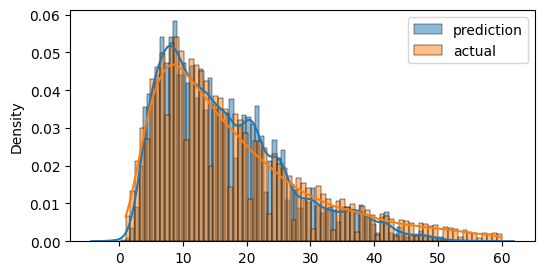

In [20]:
fig,ax = plt.subplots(1,1,figsize=(6,3))
sns.histplot(y_pred, label='prediction', ax=ax, kde=True, stat="density")
sns.histplot(y_val, label='actual', ax=ax, kde=True, stat="density")
plt.legend()
plt.show()